In [1]:
# 1. Import packages
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [34]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from keras import regularizers,initializers,callbacks
import mlflow

from time_series_helper import WindowGenerator

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
#2. Data Loading
CSV_PATH1 = os.path.join(os.getcwd(),'datasets','cases_malaysia_train.csv')
df_train = pd.read_csv(CSV_PATH1)

CSV_PATH2 = os.path.join(os.getcwd(),'datasets','cases_malaysia_test.csv')
df_test = pd.read_csv(CSV_PATH2)

In [4]:
# 3. Extract and convert the date time column
#train time
date_time_1 = pd.to_datetime(df_train.pop('date'), format='%d/%m/%Y')
#Test time
date_time_2 = pd.to_datetime(df_test.pop('date'), format='%d/%m/%Y')

In [5]:
#EDA train dataset

#Train info
df_train.info()

#Train describe
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                680 non-null    object 
 1   cases_import             680 non-null    int64  
 2   cases_recovered          680 non-null    int64  
 3   cases_active             680 non-null    int64  
 4   cases_cluster            680 non-null    int64  
 5   cases_unvax              680 non-null    int64  
 6   cases_pvax               680 non-null    int64  
 7   cases_fvax               680 non-null    int64  
 8   cases_boost              680 non-null    int64  
 9   cases_child              680 non-null    int64  
 10  cases_adolescent         680 non-null    int64  
 11  cases_adult              680 non-null    int64  
 12  cases_elderly            680 non-null    int64  
 13  cases_0_4                680 non-null    int64  
 14  cases_5_11               6

,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,cases_adolescent,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,...,680.000000,680.000000,680.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,8.788235,3766.514706,45733.016176,717.130882,2452.023529,578.805882,868.045588,4.763235,519.935294,261.016176,...,220.439706,90.754412,32.529412,0.387574,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237
std,9.162540,5622.296192,67888.984001,827.327827,3191.392812,1532.323940,1877.386774,21.433285,831.685231,433.549560,...,309.611661,132.294880,48.930226,3.441856,58.327835,189.719980,31.852769,67.309716,77.725277,491.416024
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000
25%,3.000000,46.500000,1158.250000,13.000000,46.500000,0.000000,0.000000,0.000000,2.000000,2.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,64.000000,4.000000,1.000000,5.000000,227.750000
50%,6.000000,1201.500000,14371.000000,417.500000,1257.500000,0.000000,0.000000,0.000000,109.000000,63.000000,...,57.000000,18.000000,6.000000,0.000000,5.000000,148.000000,16.500000,16.500000,42.500000,560.000000
75%,12.000000,5173.500000,64899.250000,1117.750000,3462.500000,118.250000,116.500000,0.000000,754.250000,304.000000,...,368.250000,149.250000,50.250000,0.000000,18.000000,312.000000,42.000000,41.000000,92.750000,1078.500000
max,72.000000,24855.000000,263845.000000,3394.000000,12684.000000,7313.000000,8456.000000,170.000000,3437.000000,1820.000000,...,1231.000000,581.000000,210.000000,54.000000,359.000000,825.000000,189.000000,501.000000,439.000000,2338.000000


In [6]:
#EDA test dataset

#Train info
df_test.info()

#Train describe
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                99 non-null     float64
 1   cases_import             100 non-null    int64  
 2   cases_recovered          100 non-null    int64  
 3   cases_active             100 non-null    int64  
 4   cases_cluster            100 non-null    int64  
 5   cases_unvax              100 non-null    int64  
 6   cases_pvax               100 non-null    int64  
 7   cases_fvax               100 non-null    int64  
 8   cases_boost              100 non-null    int64  
 9   cases_child              100 non-null    int64  
 10  cases_adolescent         100 non-null    int64  
 11  cases_adult              100 non-null    int64  
 12  cases_elderly            100 non-null    int64  
 13  cases_0_4                100 non-null    int64  
 14  cases_5_11               10

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
count,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,11973.808081,224.990000,9415.300000,120021.370000,320.790000,2087.390000,142.730000,5294.580000,4386.570000,1584.260000,...,678.440000,292.150000,103.280000,1.660000,2.540000,8.170000,17.600000,193.380000,11.240000,87.640000
std,11090.623017,153.883105,9226.279561,106310.747283,225.743678,1717.484212,207.250293,3781.993457,5682.907255,1387.877251,...,595.460696,268.356365,101.673381,4.288156,6.240014,9.365804,23.811125,196.628747,23.263584,56.525228
min,2342.000000,14.000000,2584.000000,39615.000000,33.000000,489.000000,11.000000,1573.000000,96.000000,349.000000,...,155.000000,64.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,3438.000000,94.750000,3398.500000,42808.250000,131.750000,740.750000,19.000000,2363.500000,252.000000,492.750000,...,242.000000,96.000000,32.000000,0.000000,0.000000,1.000000,3.000000,18.750000,0.000000,44.750000
50%,4774.000000,218.500000,4753.500000,57657.500000,279.000000,1031.500000,30.500000,3097.000000,695.000000,735.500000,...,319.500000,135.000000,45.500000,0.000000,0.000000,5.000000,10.000000,134.000000,1.000000,75.000000
75%,22951.000000,334.250000,11930.000000,221429.250000,483.250000,3846.750000,175.250000,9119.000000,9553.250000,3021.750000,...,1227.750000,536.750000,170.750000,0.000000,2.000000,10.250000,24.000000,339.000000,8.250000,118.250000
max,33406.000000,608.000000,33872.000000,323618.000000,1019.000000,5649.000000,773.000000,13079.000000,18123.000000,4389.000000,...,2060.000000,927.000000,361.000000,23.000000,40.000000,38.000000,175.000000,920.000000,141.000000,243.000000


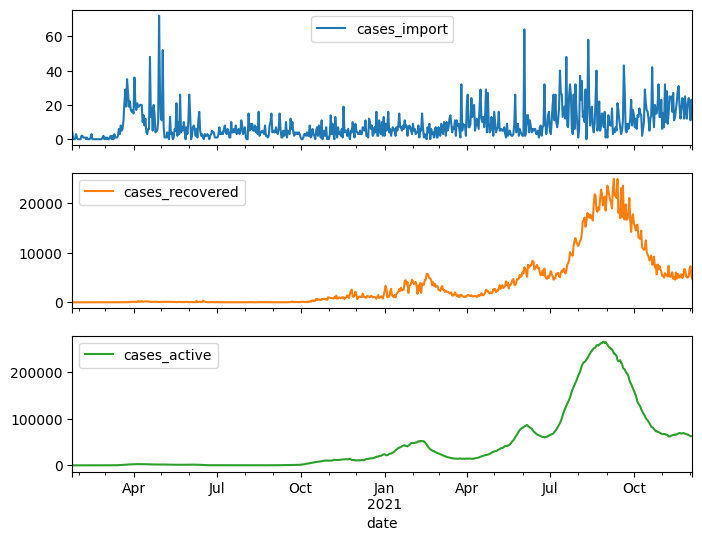

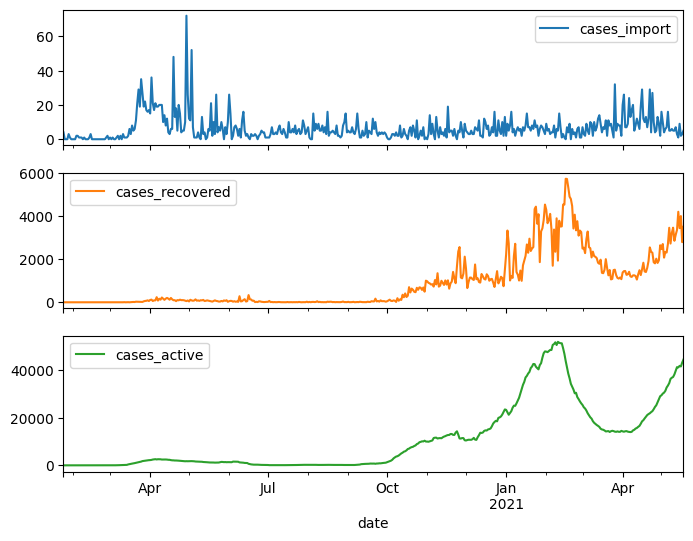

In [7]:
# 4. Data inspection
# Plot some features using matplotlib

#Train dataset
plot_cols = ['cases_import', 'cases_recovered', 'cases_active']
plot_features = df_train[plot_cols]
plot_features.index = date_time_1
_ = plot_features.plot(subplots=True)

plot_features = df_train[plot_cols][:480]
plot_features.index = date_time_1[:480]
_ = plot_features.plot(subplots=True)

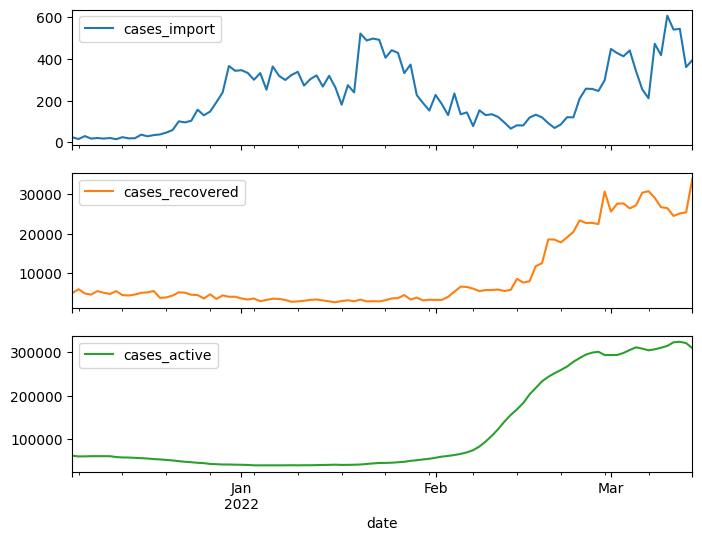

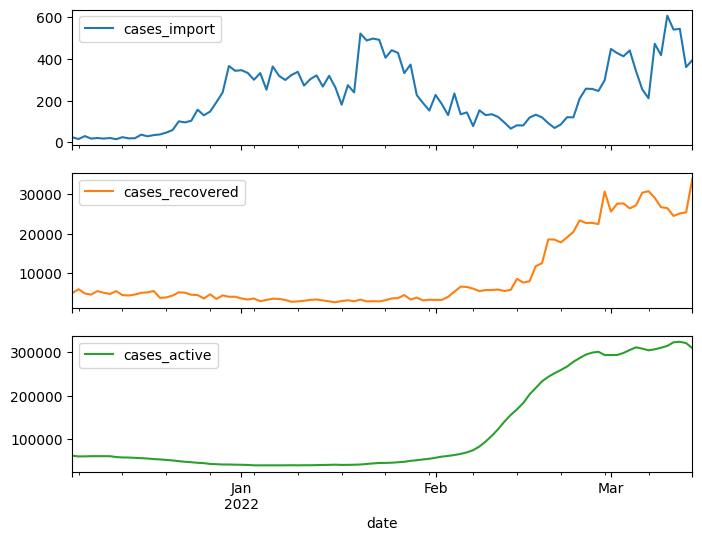

In [8]:
#Test dataset
plot_cols = ['cases_import', 'cases_recovered', 'cases_active']
plot_features = df_test[plot_cols]
plot_features.index = date_time_2
_ = plot_features.plot(subplots=True)

plot_features = df_test[plot_cols][:480]
plot_features.index = date_time_2[:480]
_ = plot_features.plot(subplots=True)

In [9]:
# 5. Data Cleaning

#Train
#Check missing values and duplicates
#print(df_train.isna().sum())
#print(df_train.duplicated().sum())

#Test
#Check missing values and duplicates
print(df_test.isna().sum())
print(df_test.duplicated().sum())

cases_new                  1
cases_import               0
cases_recovered            0
cases_active               0
cases_cluster              0
cases_unvax                0
cases_pvax                 0
cases_fvax                 0
cases_boost                0
cases_child                0
cases_adolescent           0
cases_adult                0
cases_elderly              0
cases_0_4                  0
cases_5_11                 0
cases_12_17                0
cases_18_29                0
cases_30_39                0
cases_40_49                0
cases_50_59                0
cases_60_69                0
cases_70_79                0
cases_80                   0
cluster_import             0
cluster_religious          0
cluster_community          0
cluster_highRisk           0
cluster_education          0
cluster_detentionCentre    0
cluster_workplace          0
dtype: int64
0


In [10]:
#Train dataset
# Convert object to float
df_train['cases_new'] = pd.to_numeric(df_train['cases_new'], errors='coerce')

In [11]:
# Conduct missing values
df_train = df_train.fillna(0)

In [12]:
print(df_train.isna().sum())

cases_new                  0
cases_import               0
cases_recovered            0
cases_active               0
cases_cluster              0
cases_unvax                0
cases_pvax                 0
cases_fvax                 0
cases_boost                0
cases_child                0
cases_adolescent           0
cases_adult                0
cases_elderly              0
cases_0_4                  0
cases_5_11                 0
cases_12_17                0
cases_18_29                0
cases_30_39                0
cases_40_49                0
cases_50_59                0
cases_60_69                0
cases_70_79                0
cases_80                   0
cluster_import             0
cluster_religious          0
cluster_community          0
cluster_highRisk           0
cluster_education          0
cluster_detentionCentre    0
cluster_workplace          0
dtype: int64


In [13]:
#Test dataset
# Missing values
knn = KNNImputer()

df_test["cases_new"] = knn.fit_transform(df_test[['cases_new']])

In [14]:
# 7. Data Splitting
n = df_test.shape[0]
val_df = df_test[0:int(0.8*n)]
test_df = df_test[int(0.8*n):]
#Calculate number of features
num_features = df_train.shape[1]

In [15]:
# 8. Data normalization
train_mean = df_train.mean()
train_std = df_train.std()
train_df = (df_train - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (df_test - train_mean) / train_std

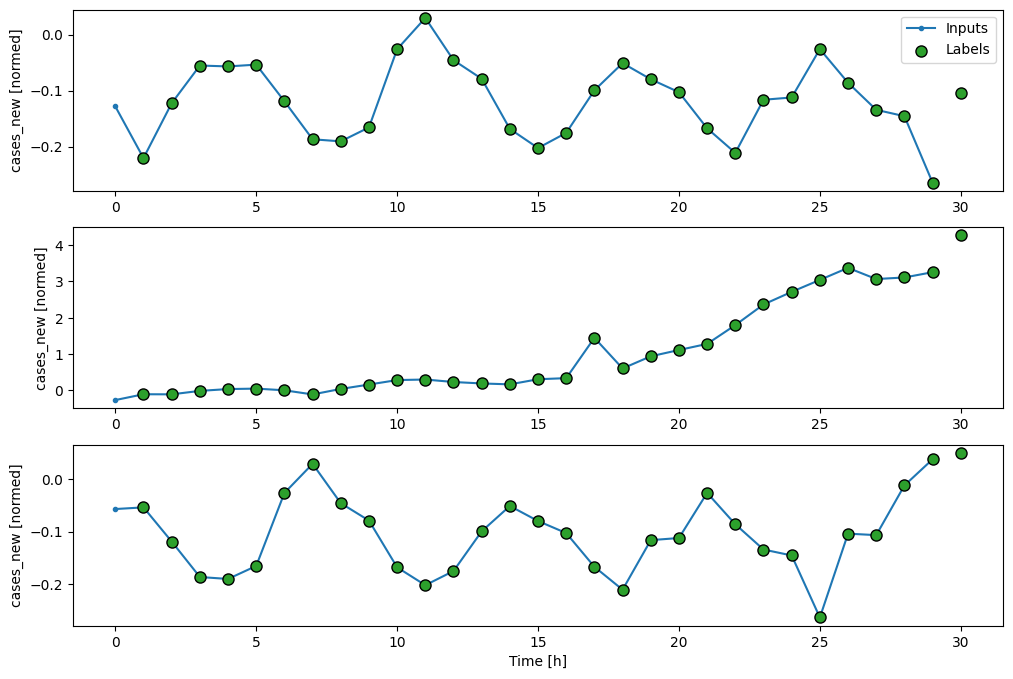

In [16]:
# Create a window for single-time-step single-output prediction
wide_window = WindowGenerator(30,30,1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=["cases_new"])
wide_window.plot(plot_col="cases_new")

In [60]:
# 10. Create an RNN (LSTM) for the wide window
model_single_step = keras.Sequential()
l2 = regularizers.L2()
model_single_step.add(keras.layers.LSTM(units=32,return_sequences=True,kernel_regularizer=l2))
model_single_step.add(keras.layers.LSTM(units=32,return_sequences=True,kernel_regularizer=l2))
model_single_step.add(keras.layers.Dense(units=1))
model_single_step.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Compile and train
model_single_step.compile(optimizer='adam',loss='mse',metrics=["mae"])

In [62]:
# Implement MLflow into keras
import mlflow
exp = mlflow.set_experiment("Covid-19")

In [63]:
# Train the model
with mlflow.start_run() as run:
    mlflow_callback = mlflow.keras.MlflowCallback(run)
    history_single = model_single_step.fit(wide_window.train,epochs=100,validation_data=wide_window.val,batch_size=32,
                                       callbacks=[mlflow_callback])
    mlflow.keras.save.log_model(model_single_step,artifact_path="model")

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6116 - mae: 0.5244 - val_loss: 1.7512 - val_mae: 0.5099
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9922 - mae: 0.2477 - val_loss: 1.6045 - val_mae: 0.5048
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7886 - mae: 0.1639 - val_loss: 1.2030 - val_mae: 0.4234
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6539 - mae: 0.1482 - val_loss: 1.0846 - val_mae: 0.4487
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5492 - mae: 0.1387 - val_loss: 1.1676 - val_mae: 0.5005
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4652 - mae: 0.1362 - val_loss: 1.1122 - val_mae: 0.4910
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3872 - mae: 0.1259 - val_loss: 1.0532 - val_mae: 0.4465
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3436 - mae: 0.1296 - val_loss: 0.9497 - val_mae: 0.3692
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

2025/03/10 14:56:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/10 14:56:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


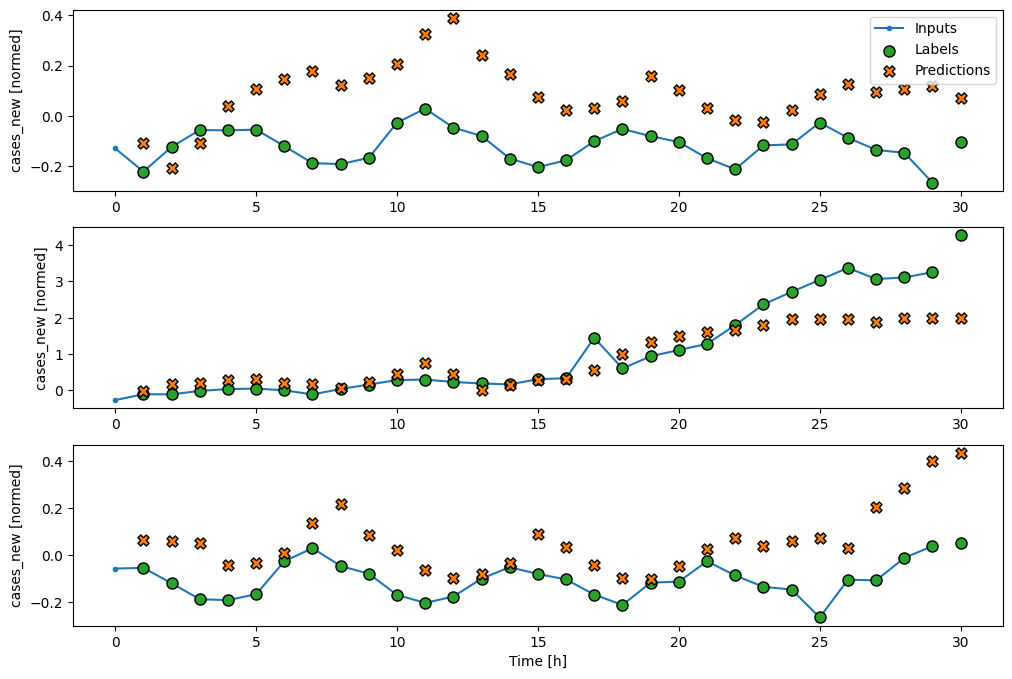

In [64]:
# Show example prediction
wide_window.plot(model=model_single_step,plot_col="cases_new")